# Intrusion type classification with NN




## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/colab_notebooks/CICIDS2017

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_notebooks/CICIDS2017


In [ ]:
import os
import pandas as pd
import numpy as np

DIR_PATH = "MachineLearningCVE"

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 12)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv(os.path.join(DIR_PATH, "processed_data.csv"))
print(df.shape)

(2520798, 67)



## Balancing the dataset by applying down sampling


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

size=len(df.loc[df.Binary_target==0])
print(size)
# downsample df.Binary_target==1 to the size of df.Binary_target==0

df1 = df[df['Binary_target'] == 1]
df2 = df[df['Binary_target'] == 0]
df1 = df1.sample(n=len(df2))
bal_df = pd.concat([df1, df2])
# shuffle the dataset
bal_df = bal_df.sample(frac=1).reset_index(drop=True)
# sns.countplot(data=bal_df,x='Binary_target')
bal_df.shape

425741


(851482, 67)

In [ ]:
bal_df.Label.value_counts()

Label
BENIGN                      425741
DoS Hulk                    172846
DDoS                        128014
PortScan                     90694
DoS GoldenEye                10286
FTP-Patator                   5931
DoS slowloris                 5385
DoS Slowhttptest              5228
SSH-Patator                   3219
Bot                           1948
Web Attack-Brute Force        1470
Web Attack-XSS                 652
Infiltration                    36
Web Attack-Sql Injection        21
Heartbleed                      11
Name: count, dtype: int64

We see that intrusions of type Infiltration, Web Attack-Sql Injection and Heartbleed are rare.

The model will not recognize them,

And it is additional three classes that can harm the model accuracy and efficiency.

We shall change their category to Web Attack-XSS and add their samples to that class.

In [ ]:
bal_df['Label'] = bal_df.apply(lambda row: 'Web Attack-XSS' if row['Label'] in ['Infiltration', 'Web Attack-Sql Injection', 'Heartbleed'] else row['Label'], axis=1)
bal_df.Label.value_counts()
bal_df_copy = bal_df.copy()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

intrusion_types = list(bal_df['Label'].unique())
intrusion_types.remove('BENIGN')
intrusion_types.insert(0, 'BENIGN')
print(intrusion_types)
y = bal_df['Label'].to_numpy()
y = np.vectorize(intrusion_types.index)(y)

output_size = len(np.unique(y))
print(output_size)
bal_df.drop(columns=['Label', 'Binary_target'], inplace=True)
X = MinMaxScaler().fit_transform(bal_df)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(X_train.shape," ",X_test.shape)
print(y_train.shape," ",y_test.shape)


['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'DoS GoldenEye', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'SSH-Patator', 'Bot', 'Web Attack-Brute Force', 'Web Attack-XSS']
12
(681185, 65)   (170297, 65)
(681185,)   (170297,)


# Training and evaluating after down sampling:

In [ ]:
import torch
import torch.nn as nn

'''
Creating a Model for Prediction
'''

class Model(nn.Module):
    def __init__(self, num_numerical_cols, output_size, layers, p=0.4):
        # num_numerical_cols: Stores the total number of numerical columns
        # output_size: The size of the output layer or the number of possible outputs.
        # layers: List which contains number of neurons for all the layers.
        # p: Dropout with the default value of 0.4
        super().__init__()
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)
        all_layers = []
        input_size = num_numerical_cols

        # Linear: Used to calculate the dot product between the inputs and weight matrixes
        # ReLu: Which is applied as an activation function
        # BatchNorm1d: Used to apply batch normalization to the numerical columns. Accelerating Deep Network Training by Reducing Internal Covariate Shift
        # Dropout: Used to avoid overfitting
        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_numerical):
        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x_numerical], 1)
        x = self.layers(x)
        return x

'''
Parameters:
the number of numerical columns
the output size
the neurons in the hidden layers (can choose any other size)
'''
model = Model(num_numerical_cols=X_train.shape[1], output_size=output_size, layers=[256,128,64], p=0.4)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

Model(
  (batch_norm_num): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=65, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=64, out_features=12, bias=True)
  )
)


# Train the model

In [ ]:
'''
Training the Model
'''
epochs = 80
aggregated_losses = []
train_data = torch.tensor(X_train).to(torch.float32)
train_y = torch.tensor(y_train).to(torch.long)

for i in range(epochs):
    i += 1
    y_pred = model(train_data)
    single_loss = loss_function(y_pred, train_y)
    aggregated_losses.append(single_loss)

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.5f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.5f}')

# Convert the aggregated losses tensor to a NumPy array
# aggregated_losses = aggregated_losses.detach().numpy()

# plt.plot(range(epochs), aggregated_losses)
# plt.ylabel('Loss')
# plt.xlabel('epoch');

epoch:   1 loss:    2.67052
epoch:  11 loss:    1.30158
epoch:  21 loss:    0.82473
epoch:  31 loss:    0.57899
epoch:  41 loss:    0.44834
epoch:  51 loss:    0.37456
epoch:  61 loss:    0.32776
epoch:  71 loss:    0.29438
epoch:  80 loss:    0.26926


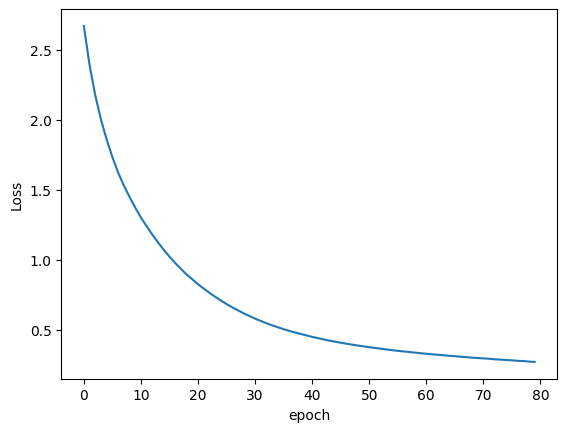

In [ ]:
# Convert aggregated_losses to a list of floats and display the loss chart
aggregated_losses = [loss.item() for loss in aggregated_losses]

plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

# Evaluate the training results

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

# predict on the test data
y_pred = model(torch.tensor(X_test).to(torch.float32))
y_pred = torch.max(y_pred, 1)[1].data.numpy()

cm = confusion_matrix(y_test, y_pred)
# print(cm)

# replace the row names in the classification report their values in list intrusion_types

cr = classification_report(y_test,y_pred, labels=list(range(0, len(intrusion_types))), target_names=intrusion_types)
print(cr)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

                BENIGN       0.94      0.96      0.95     85048
              PortScan       0.87      0.97      0.92     18320
              DoS Hulk       0.95      0.97      0.96     34398
                  DDoS       0.96      0.98      0.97     25548
         DoS GoldenEye       0.93      0.56      0.70      2117
      DoS Slowhttptest       0.85      0.57      0.68      1109
         DoS slowloris       0.68      0.38      0.49      1077
           FTP-Patator       0.69      0.01      0.02      1177
           SSH-Patator       0.00      0.00      0.00       677
                   Bot       0.00      0.00      0.00       403
Web Attack-Brute Force       0.00      0.00      0.00       283
        Web Attack-XSS       0.00      0.00      0.00       140

              accuracy                           0.94    170297
             macro avg       0.57      0.45      0.47    170297
          weighted avg       0.93     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# The results are OK but not good enough

Let's make it more accurate by applying the binary model first, and if it detects an intrusion, we apply the NN model to classify the type of the intrusion.

Since we have a model that classifies intrusions very accurately,

We shall run this model on an instance, and if it is classidied as intrusion, we shall run a model that classifies the intrusion type of the instance.

For that, we just need to remove the instances with Label 'BENIGN' from the dataset, so the dataset will contain only intrusions, and train a model that classifies the intrusion type.

In [ ]:
# remove all instances where 'Label' == 'BENIGN'
bal_df_copy = bal_df_copy[bal_df_copy['Label'] != 'BENIGN']

intrusion_types = list(bal_df_copy['Label'].unique())

y = bal_df_copy['Label'].to_numpy()
y = np.vectorize(intrusion_types.index)(y)

output_size = len(np.unique(y))
print(output_size)
bal_df_copy.drop(columns=['Label', 'Binary_target'], inplace=True)
X = MinMaxScaler().fit_transform(bal_df_copy)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(X_train.shape," ",X_test.shape)
print(y_train.shape," ",y_test.shape)

model = Model(num_numerical_cols=X_train.shape[1], output_size=output_size, layers=[256,128,64], p=0.4)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)


11
(340592, 65)   (85149, 65)
(340592,)   (85149,)
Model(
  (batch_norm_num): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=65, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=64, out_features=11, bias=True)
  )
)


In [ ]:
'''
Training the Model
'''
epochs = 80
aggregated_losses = []
train_data = torch.tensor(X_train).to(torch.float32)
train_y = torch.tensor(y_train).to(torch.long)

for i in range(epochs):
    i += 1
    y_pred = model(train_data)
    single_loss = loss_function(y_pred, train_y)
    aggregated_losses.append(single_loss)

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.5f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.5f}')

epoch:   1 loss:    2.59495
epoch:  11 loss:    1.04161
epoch:  21 loss:    0.62672
epoch:  41 loss:    0.28759
epoch:  51 loss:    0.22063
epoch:  61 loss:    0.17783
epoch:  71 loss:    0.14826
epoch:  80 loss:    0.12846


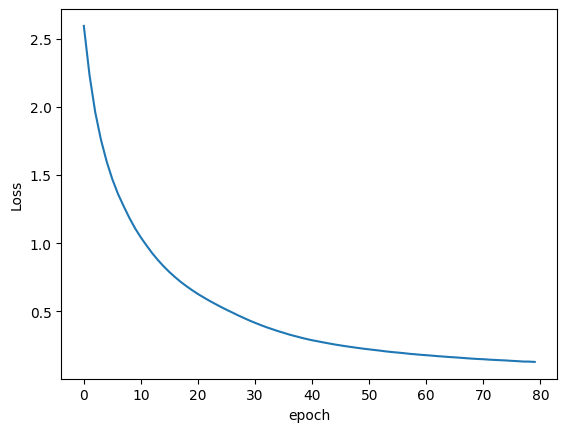

In [ ]:
# Convert aggregated_losses to a list of floats and display the loss chart
aggregated_losses = [loss.item() for loss in aggregated_losses]

plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

# Evaluate the training results of the 2nd model

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

# predict on the test data
y_pred = model(torch.tensor(X_test).to(torch.float32))
y_pred = torch.max(y_pred, 1)[1].data.numpy()

cm = confusion_matrix(y_test, y_pred)
# print(cm)

# replace the row names in the classification report their values in list intrusion_types

cr = classification_report(y_test,y_pred, labels=list(range(0, len(intrusion_types))), target_names=intrusion_types)
print(cr)


                        precision    recall  f1-score   support

              PortScan       0.98      0.99      0.98     18112
              DoS Hulk       0.99      1.00      0.99     34807
                  DDoS       1.00      1.00      1.00     25429
         DoS GoldenEye       0.91      0.93      0.92      2098
      DoS Slowhttptest       0.84      0.75      0.79      1032
         DoS slowloris       0.81      0.73      0.76      1082
           FTP-Patator       0.78      0.93      0.85      1171
           SSH-Patator       0.82      0.78      0.80       631
                   Bot       0.61      0.13      0.21       370
Web Attack-Brute Force       0.40      0.20      0.27       281
        Web Attack-XSS       0.12      0.01      0.01       136

              accuracy                           0.98     85149
             macro avg       0.75      0.68      0.69     85149
          weighted avg       0.97      0.98      0.98     85149



# This is much better